In [138]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime
import math 
import QuantLib as ql
from scipy.optimize import minimize

data = "COFFEE"

df = pd.DataFrame()

eonia_rates = pd.read_csv(r'eonia.csv', sep=";")

def date_pd_to_ql(date):
    date = pd.to_datetime(date)
    day = date.day
    month = date.month
    year = date.year

    return ql.Date(day, month, year)

current_time = current_price = ATM_price = None

if data == "SPX":
    df = pd.read_csv(r'spx_SABR.csv')
    df['Date'] = pd.to_datetime(df['Date'], format='%y%m%d')

    # Remove strikes from Dataframe
    fltr = np.arange(3100., 4600., 100) 
    df = df[df['Strike'].isin(fltr)]

    current_time = pd.Timestamp(year=2021, month=8, day=3, hour=12)
    today = date_pd_to_ql(current_time)
    current_price = 4300.
    ATM_price = 4300.
    
elif data == "NASDAQ":
    df = pd.read_csv(r'NASDAQ.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%Y')

    # Remove strikes from Dataframe
    fltr = np.arange(11000., 18000., 200) 
    df = df[df['Strike'].isin(fltr)]
    df["IV"] = df["IV"] / 100

    current_time = pd.Timestamp(year=2021, month=8, day=30, hour=19)
    today = date_pd_to_ql(current_time)
    current_price = 15605.
    ATM_price = 15600.

elif data == "OIL":
    df = pd.read_csv(r'oil.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%y')

    # Remove strikes from Dataframe
    fltr = [41,45,47,48,50,52,54,55,60,62,64,66,70,72,75,80]
    df = df[df['Strike'].isin(fltr)]
    df["IV"] = df["IV"] / 100

    current_time = pd.Timestamp(year=2021, month=8, day=30, hour=19)
    today = date_pd_to_ql(current_time)
    current_price = 67.61
    ATM_price = 66.

elif data == "GOLD":
    df = pd.read_csv(r'gold.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%y')

    # Remove strikes from Dataframe
    fltr = np.arange(1400., 2250., 50) 
    df = df[df['Strike'].isin(fltr)]
    df["IV"] = df["IV"] / 100

    current_time = pd.Timestamp(year=2021, month=8, day=31, hour=19)
    today = date_pd_to_ql(current_time)
    current_price = 1820.
    ATM_price = 1800.

elif data == "COFFEE":
    df = pd.read_csv(r'coffee.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%y')

    # Remove strikes from Dataframe
    fltr = np.arange(100., 300., 10) 
    df = df[df['Strike'].isin(fltr)]
    df["IV"] = df["IV"] / 100

    current_time = pd.Timestamp(year=2021, month=8, day=31, hour=19)
    today = date_pd_to_ql(current_time)
    current_price = 200.
    ATM_price = 200.

maturities = df["Date"].unique()
strikes = df["Strike"].unique()

ql.Settings.instance().evaluationDate = today
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()

spot_quote = ql.QuoteHandle(ql.SimpleQuote(current_price))
rate = ql.SimpleQuote(-0.00482)
riskFreeCurve = ql.FlatForward(today, ql.QuoteHandle(rate), ql.Actual365Fixed())
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(riskFreeCurve)

vols = [np.array(df[df["Date"] == maturities[m]]["IV"]) for m in range(len(maturities))]

plot_size = (12, 5)

dates = [date_pd_to_ql(d) for d in maturities]

Tenors  Spot Rate
0    0.25     -0.575
1    1.00     -0.557
2    3.00     -0.549
3    6.00     -0.529
4   12.00     -0.494

Text(0.5, 1.0, 'EONIA Rates (%) 1996-2021')

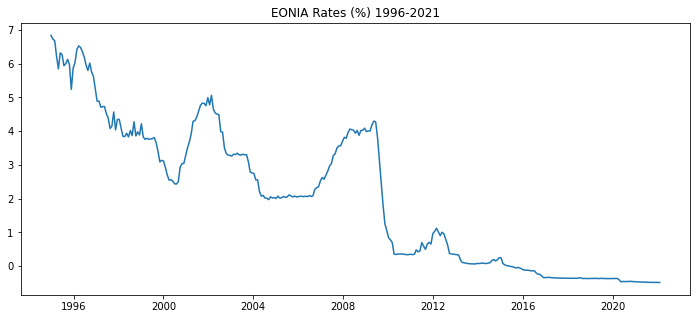

In [139]:
# Spot rates table and chart (EONIA)

rates = [-0.575, -0.557, -0.549, -0.529, -0.494]
tenors = [.25, 1, 3, 6, 12]

spot_rates = pd.DataFrame({"Tenors": tenors, "Spot Rate": rates})
spot_rates.set_index('Tenors')

display(spot_rates)

fig = plt.figure(figsize=(12,5))
eonia_dates = [datetime.date(1994, 12, 31) + datetime.timedelta(days=30*n) for n in range(len(eonia_rates['value']))]
plt.plot(eonia_dates, eonia_rates['value'])
plt.title("EONIA Rates (%) 1996-2021")

In [140]:
#Plot volatility Surface
def plot_vol_surface(vol_surface, plot_years=np.arange(0.1, (dates[-1] - today) / 365., 0.1), plot_strikes=strikes, funct='blackVol', title="", size=plot_size):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Maturities')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(title)
    X, Y = np.meshgrid(plot_strikes, plot_years)

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                          for x, y in zip(xr,yr) ]
                     ).reshape(len(X), len(X[0]))

        surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, linewidth=0.3)

def plot_smile(date, smiles, bounds=None, market=True, title="", size=(15, 4)):

    market_vols = vols[dates.index(date)]

    fig, ax = plt.subplots(figsize=size)
    for smile in smiles:
        ax.plot(strikes, smile[0], label=smile[1])
    if market:
        ax.plot(strikes, market_vols, "rX", label="Actual")
        ax.plot([ATM_price], market_vols[strikes.tolist().index(ATM_price)], "o", label="ATM")
    
    if bounds:
        ax.set_xbound(bounds[0], bounds[1])
        
    ax.set_title(title)
    ax.set_xlabel("Strikes", size=12)
    ax.set_ylabel("Vols", size=12)
    legend = ax.legend(loc="upper right")

# Plot Volatility Smile Comparisons

def smiles_comparison(models, heston_models=[], points=(.2, .4, .6, .8, 1)):
        for i in [round((len(dates)-1) * x) for x in points]:
                tenor = dates[i]
                l = [([model.vol_surface.blackVol(tenor, s) for s in strikes], model.label) for model in models]
                if len(heston_models) > 0:
                        l.extend([([x.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston" ) for x in heston_models])

                plot_smile(tenor, l, title="Volatility Smile for options expiring on {}".format(tenor))


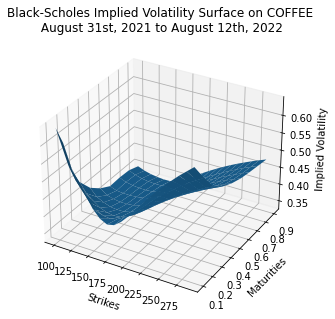

In [141]:
# BLACK VOLATILITY SURFACE

volMatrix = ql.Matrix(len(strikes), len(dates))

for i in range(len(vols)):
    for j in range(len(vols[i])):
        volMatrix[j][i] = vols[i][j]

black_var_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, volMatrix, day_count)
black_var_surface.enableExtrapolation()

title = "Black-Scholes Implied Volatility Surface on {}\n {} to {}".format(data, today, dates[-1])
plot_vol_surface(vol_surface=black_var_surface, plot_strikes=strikes, funct='blackVol', title=title)

In [142]:
#CALIBRATE SABR VOLATILITY SURFACE

class SABRSmile:
    def __init__(self, date, shift=0, beta=1, method="normal", fwd=current_price, zero_rho=False):
        self.date = date
        self.expiryTime = round((self.date - today)/365, 6)
        self.marketVols = vols[dates.index(self.date)]
        self.shift = shift
        self.fwd = fwd
        self.forward_price = self.fwd * math.exp(rate.value() * self.expiryTime)
        self.zero_rho = zero_rho
        self.alpha, self.beta, self.nu, self.rho = (.1, beta, 0., 0. if self.zero_rho else .1)
        self.method = method
        self.newVols = None
        self.error = None

    def initialize(self):
        # alpha, beta, nu, rho
        cons = (
        {'type': 'ineq', 'fun': lambda x: x[0] - 0.001},
        {'type': 'eq', 'fun': lambda x: x[1] - self.beta},
        {'type': 'ineq', 'fun': lambda x: x[2] -.001},
        {'type': 'ineq', 'fun': lambda x: .99 - x[3]**2},
        )

        x = self.set_init_conds()

        result = minimize(self.f, x, constraints=cons, method="SLSQP")
        self.error = result['fun']
        [self.alpha, self.beta, self.nu, self.rho] = result['x']
    
        self.newVols = [self.vols_by_method(strike, self.alpha, self.beta, self.nu, self.rho) for strike in strikes]

    def set_init_conds (self):
        return [self.alpha, self.beta, self.nu, self.rho]

    def vols_by_method(self, strike, alpha, beta, nu, rho):
        if self.method == "floch-kennedy":
            return ql.sabrFlochKennedyVolatility(strike, self.forward_price, self.expiryTime, alpha, beta, nu, rho)
        elif self.shift != 0:
            return ql.shiftedSabrVolatility(strike, self.forward_price, self.expiryTime, alpha, beta, nu, rho, self.shift)
        else:
            return ql.sabrVolatility(strike, self.forward_price, self.expiryTime, alpha, beta, nu, rho)

    def f(self, params):

        alpha, beta, nu, rho = params

        beta = self.beta
        alpha = max(alpha, 1e-8) # Avoid alpha going negative
        nu = max(nu, 1e-8) # Avoid nu going negative
        rho = max(rho, -0.999) if self.zero_rho==False else 0.0 # Avoid rhp going < -1.0 or set zero correlation
        rho = min(rho, 0.999) # Avoid rho going > 1.0

        vols = np.array([self.vols_by_method(strike, alpha, beta, nu, rho) for strike in strikes])

        self.error = ((vols - np.array(self.marketVols))**2 ).mean() **.5

        return self.error


class SABRVolatilitySurface:
    def __init__(self, method="normal", beta=1, shift=0, fwd=current_price, label="", zero_rho=False):
        self.method = method
        self._beta = beta
        self.shift = shift
        self.fwd = fwd
        self.label = label
        self.zero_rho = zero_rho

        self.initialize()

    def initialize(self):
        self.vol_surface_vector, self.errors, self.smiles, self.alpha, self.beta, self.nu, self.rho = [], [], [], [], [], [], []
        self.SABRVolMatrix, self.SABRVolDiffMatrix = (ql.Matrix(len(strikes), len(dates)), ql.Matrix(len(strikes), len(dates)))
        
        for i, d in enumerate(dates):
            volSABR = SABRSmile(date=d, beta=self._beta, shift=self.shift, method=self.method, fwd=self.fwd, zero_rho=self.zero_rho)
            volSABR.initialize()

            self.alpha.append(volSABR.alpha)
            self.beta.append(volSABR.beta)
            self.nu.append(volSABR.nu)
            self.rho.append(volSABR.rho)
            
            self.errors.append(volSABR.error)

            smile = volSABR.newVols

            self.vol_surface_vector.extend(smile)
            self.smiles.append(volSABR)

            #constructing the SABRVolatilityMatrix
            for j in range(len(smile)):
                self.SABRVolMatrix[j][i] = smile[j]
                self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]
            
            self.vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, self.SABRVolMatrix, day_count)
            self.vol_surface.enableExtrapolation()

    def to_data(self):
        d = {'alpha': self.alpha, 'beta': self.beta, 'nu': self.nu, 'rho': self.rho}
        return pd.DataFrame(data=d, index=dates)


# Backbone modelling for SABR
def SABR_backbone_plot (beta=1, bounds=None, shift=0, fixes=(.95, 1, 1.14, 1.24), tenor=dates[2]):
    l = []
    for i in fixes:
        vol_surface = SABRVolatilitySurface(method="normal", shift=current_price*shift, beta=beta, fwd=current_price * i)
        SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, vol_surface.SABRVolMatrix, day_count)
        SABR_vol_surface.enableExtrapolation()

        l.append( ([SABR_vol_surface.blackVol(tenor, s) for s in strikes], "fwd = {}".format(current_price * i) ) )
        
    plot_smile(tenor, l, bounds=bounds, market=False, title="backbone, beta = {}, {}".format(vol_surface.beta[0], tenor))

alpha  beta        nu       rho
September 10th, 2021  0.640799   1.0  0.001000  0.100328
October 8th, 2021     0.434504   1.0  1.934275  0.382189
November 12th, 2021   0.429955   1.0  1.380172  0.471453
February 10th, 2022   0.396276   1.0  0.869200  0.556212
April 8th, 2022       0.386841   1.0  0.755767  0.574260
June 10th, 2022       0.368053   1.0  0.796920  0.537327
August 12th, 2022     0.360970   1.0  0.760981  0.591462

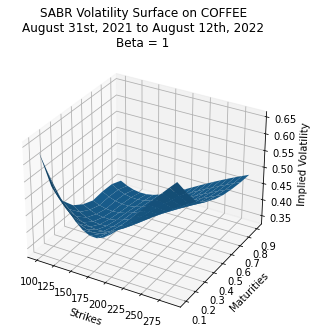

In [143]:
#SABR VOLATILITY SURFACE

volatility_surface = SABRVolatilitySurface(beta=1)
SABRVolMatrix = volatility_surface.SABRVolMatrix

SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, SABRVolMatrix, day_count)
SABR_vol_surface.enableExtrapolation()

title = "SABR Volatility Surface on {}\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface(vol_surface=SABR_vol_surface, title=title)

volatility_surface.to_data()

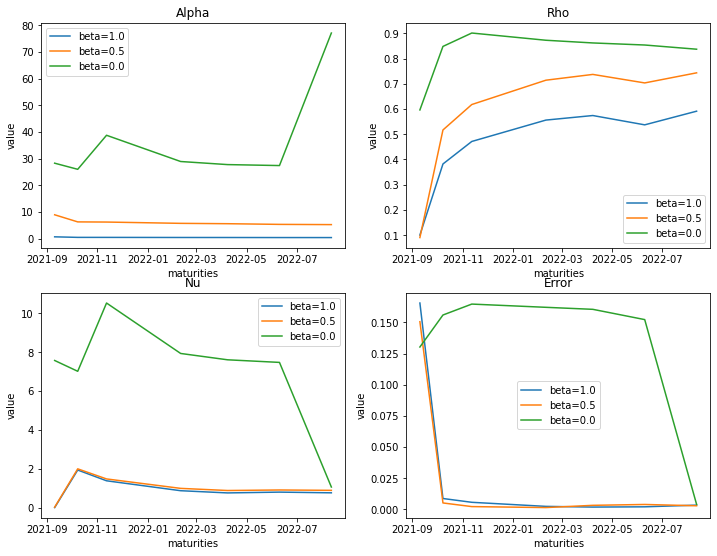

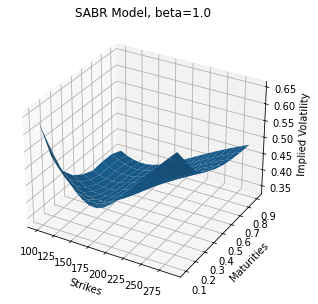

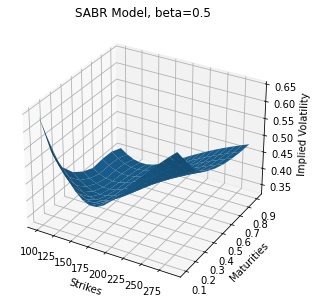

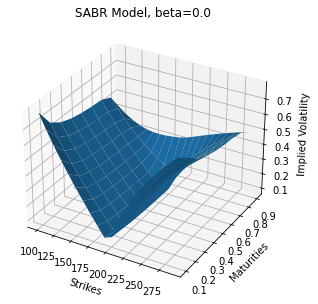

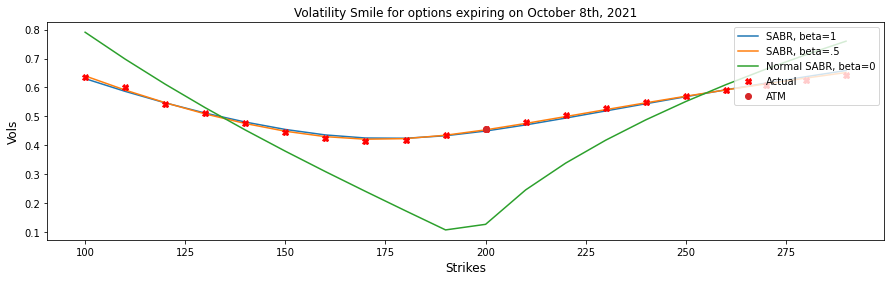

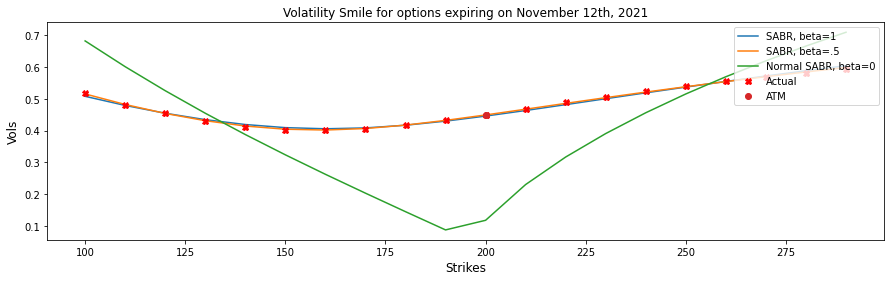

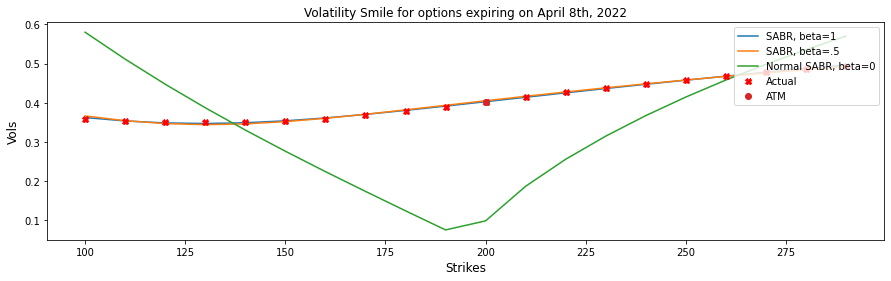

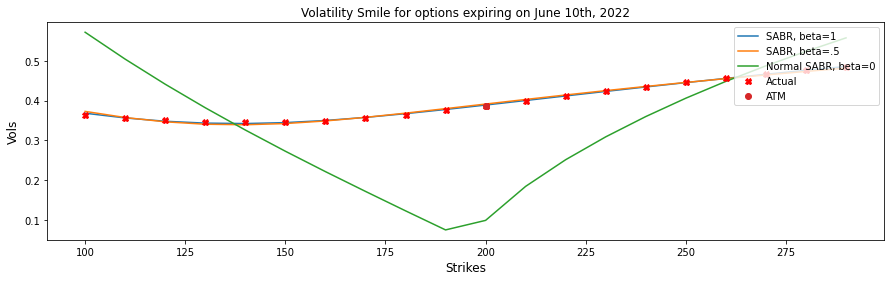

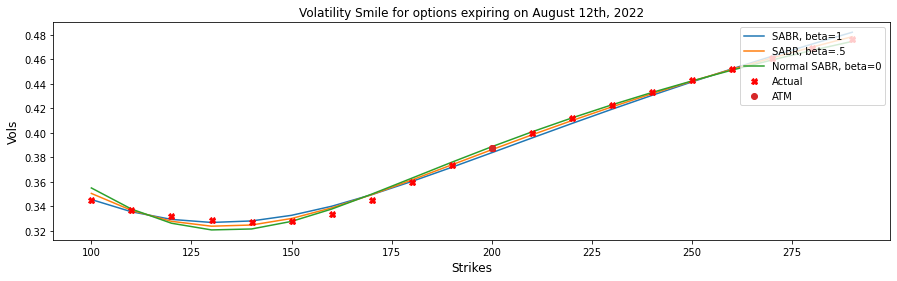

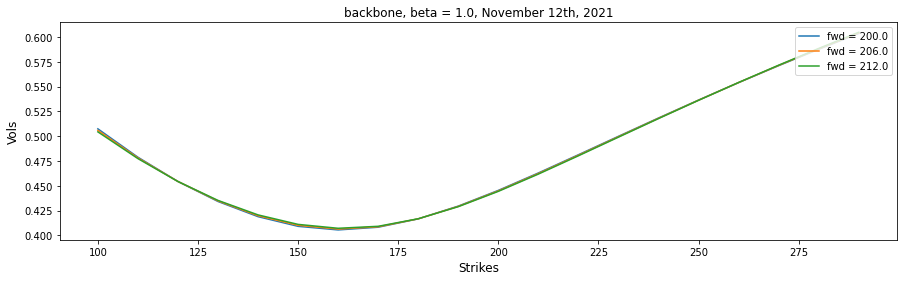

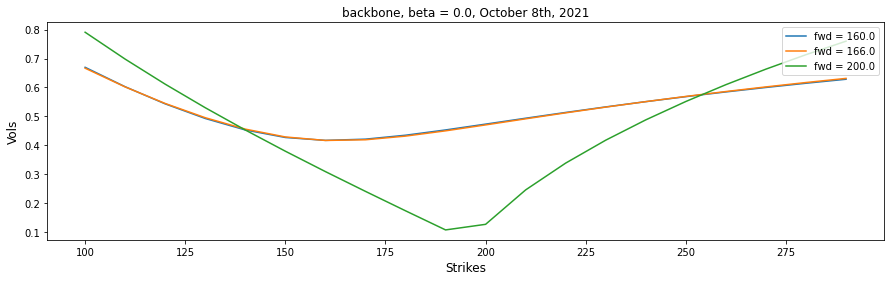

In [144]:
# SABR Volatility model

SABR_beta1 = SABRVolatilitySurface(beta=1, shift=0, label="SABR, beta=1")
SABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, label="SABR, beta=.5")
SABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, label="Normal SABR, beta=0")

def SABRComparison(methods, title="", display=False):
    fig, axs = plt.subplots(2, 2, figsize=plot_size)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
    for method in methods:
        lbl = "beta={}".format(method.beta[1])
        axs[0, 0].plot(maturities, method.alpha, label=lbl)
        axs[0, 0].set_title('Alpha')
        axs[0, 0].set(xlabel='maturities', ylabel='value')
        axs[0, 0].legend()
        axs[1, 0].plot(maturities, method.nu, label=lbl)
        axs[1, 0].set_title('Nu')
        axs[1, 0].set(xlabel='maturities', ylabel='value')
        axs[1, 0].legend()
        axs[0, 1].plot(maturities, method.rho, label=lbl)
        axs[0, 1].set_title('Rho')
        axs[0, 1].set(xlabel='maturities', ylabel='value')
        axs[0, 1].legend()
        axs[1, 1].plot(maturities, method.errors, label=lbl)
        axs[1, 1].set_title('Error')
        axs[1, 1].set(xlabel='maturities', ylabel='value')
        axs[1, 1].legend()
        
        if display:
            method_df = method.to_data()
            display(method_df.style.set_caption("SABR, {}".format(lbl)))

        plot_vol_surface(method.vol_surface, title="{}, {}".format(title, lbl))

    smiles_comparison(methods)

        
SABRComparison([SABR_beta1, SABR_beta5, SABR_beta0], title="SABR Model")

# SABR Backbone modelling
fix = (1, 1.2, 1.3) if data == "NASDAQ" else (1, 1.03, 1.06)

b = (current_price*.95, current_price*1.07) if data == "SPX" else (strikes[0], strikes[-1])
SABR_backbone_plot(fixes = fix, )
SABR_backbone_plot(beta=0, fixes = (.8, .83, 1), tenor = dates[-6])

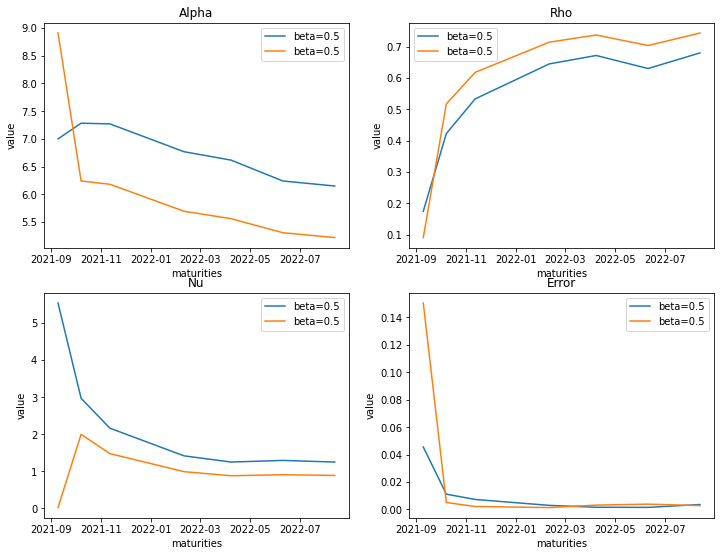

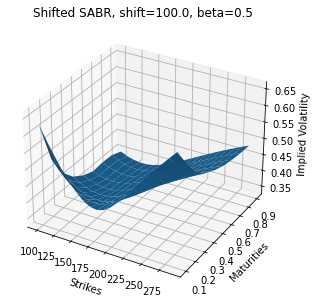

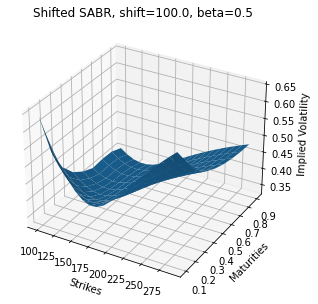

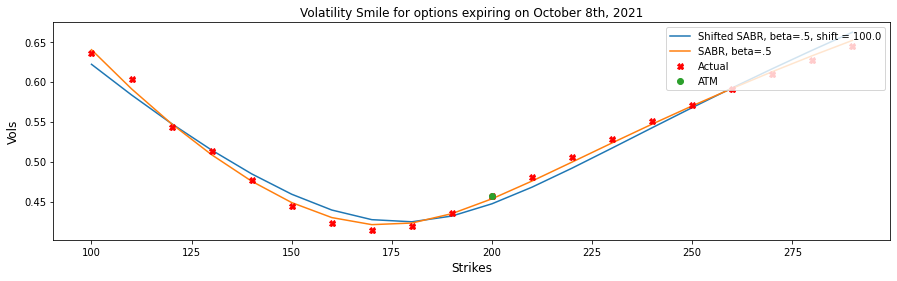

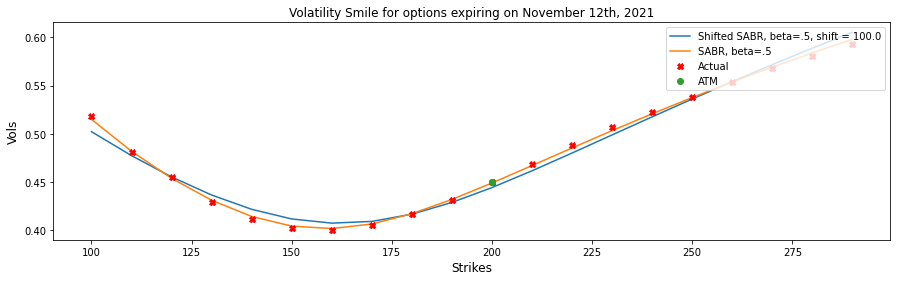

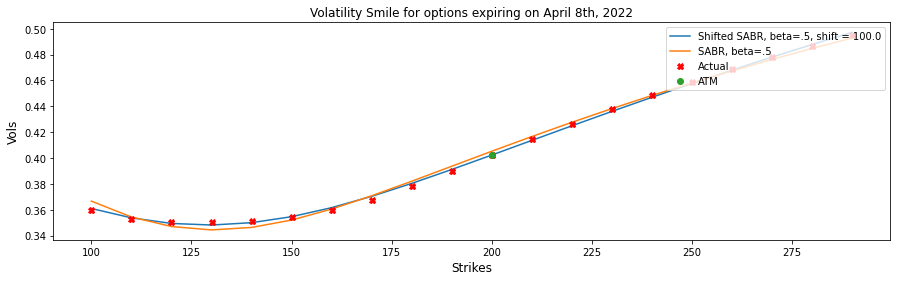

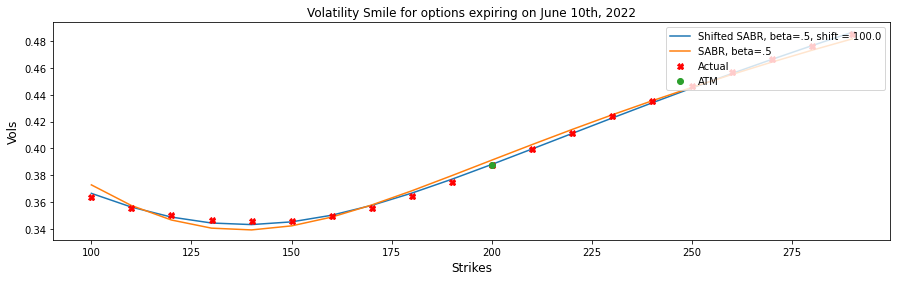

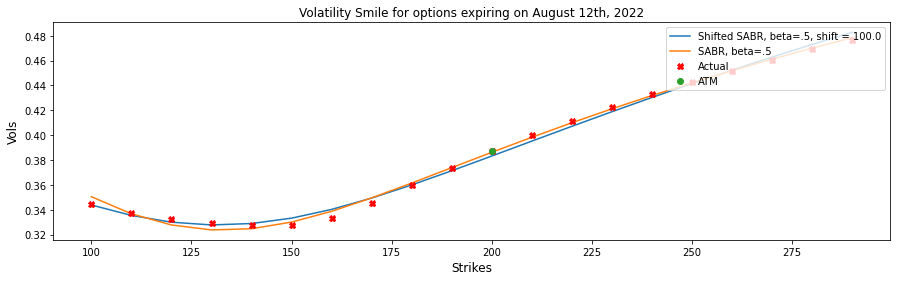

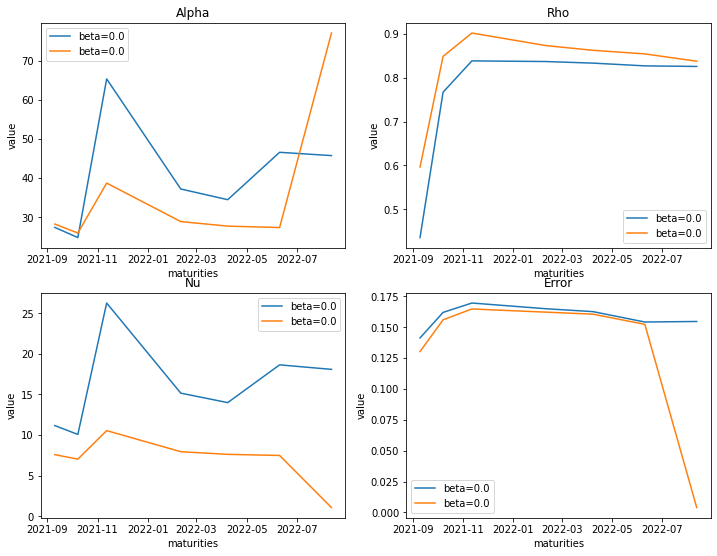

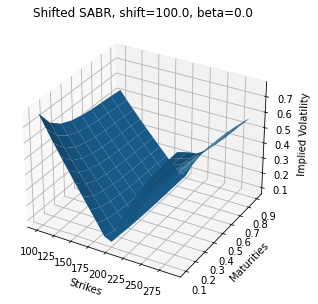

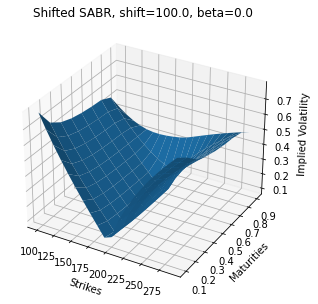

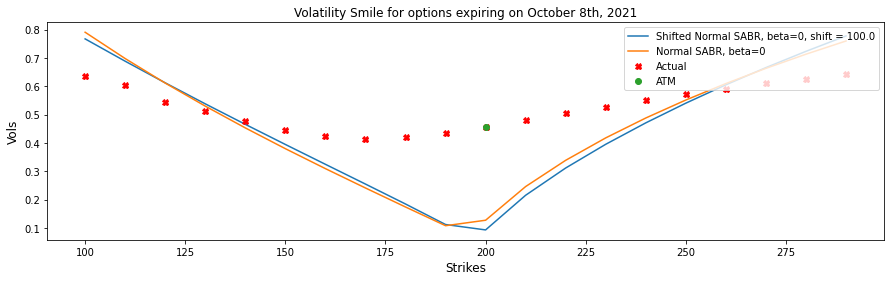

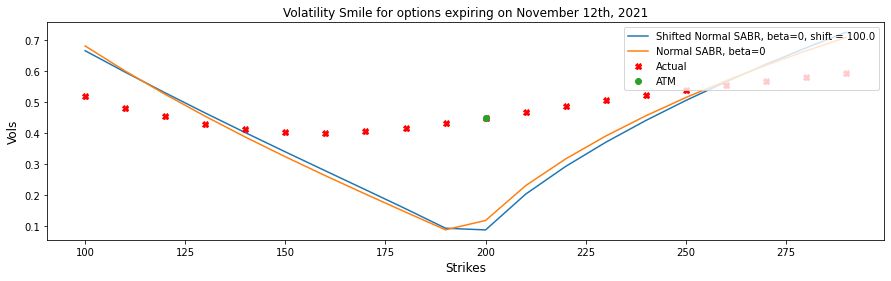

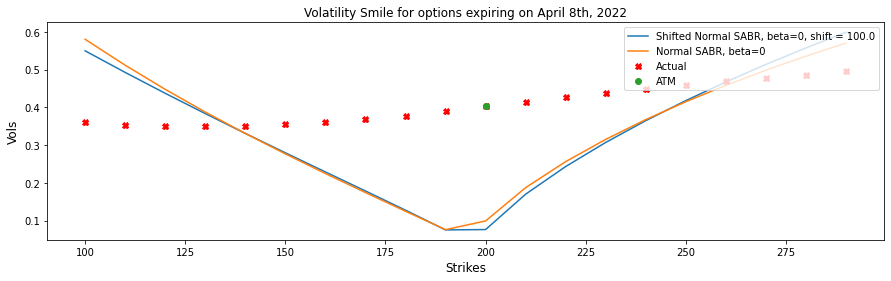

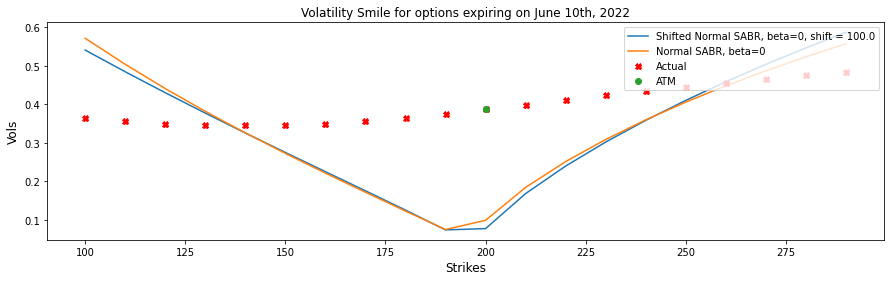

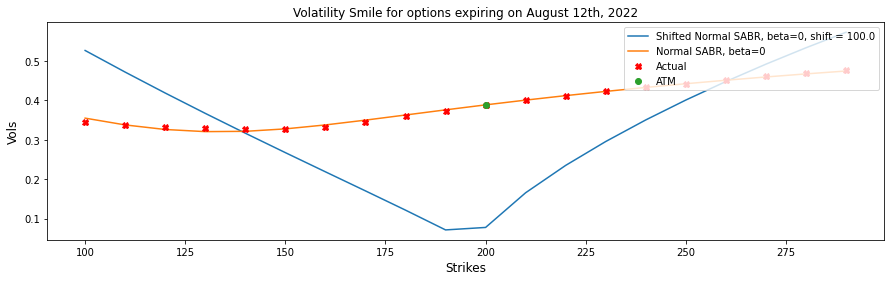

In [145]:
# Shifted SABR Volatility model
shft = .50 * current_price
shiftedSABR_beta1 = SABRVolatilitySurface(beta=1, shift=shft, label="Shifted SABR, beta=1, shift = {}".format(round(shft, 4)))
shiftedSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=shft, label="Shifted SABR, beta=.5, shift = {}".format(round(shft, 4)))
shiftedSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=shft, label="Shifted Normal SABR, beta=0, shift = {}".format(round(shft, 4)))

SABRComparison([shiftedSABR_beta5, SABR_beta5], title="Shifted SABR, shift={}".format(round(shft, 4)))
SABRComparison([shiftedSABR_beta0, SABR_beta0], title="Shifted SABR, shift={}".format(round(shft, 4)))

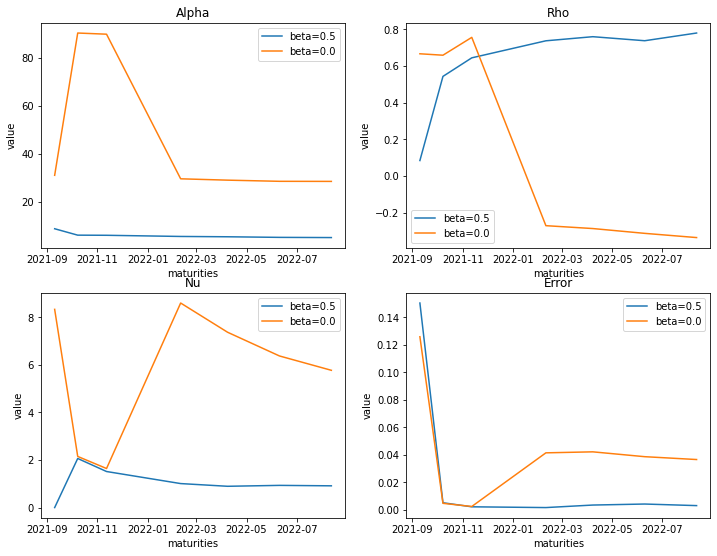

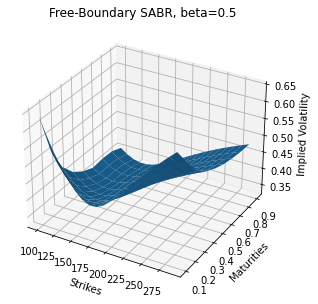

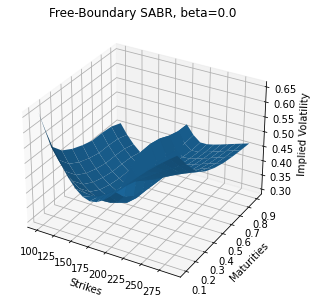

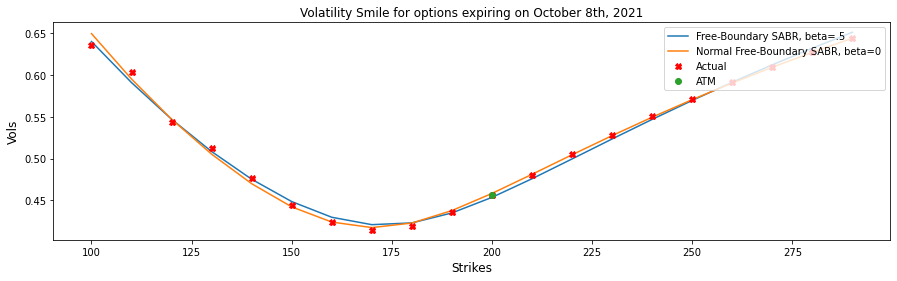

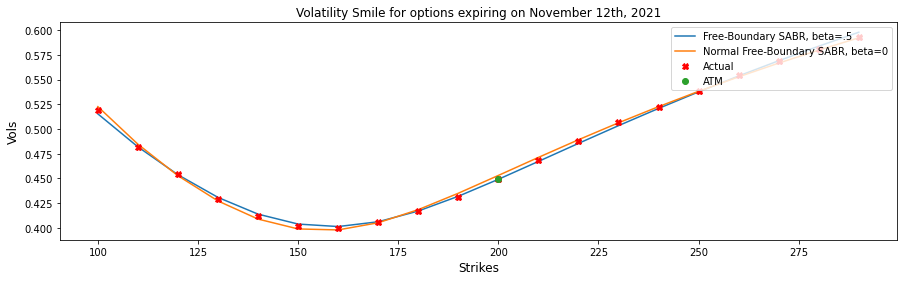

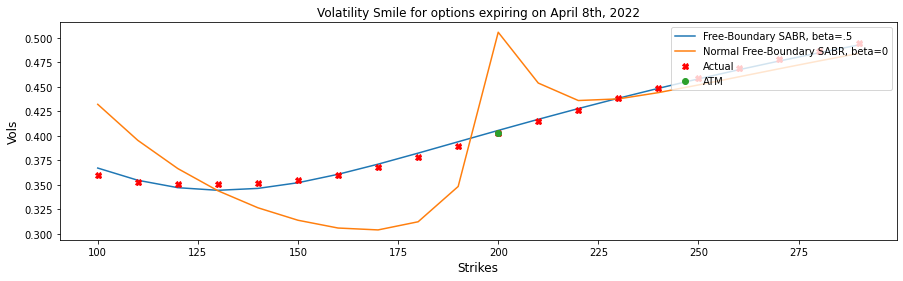

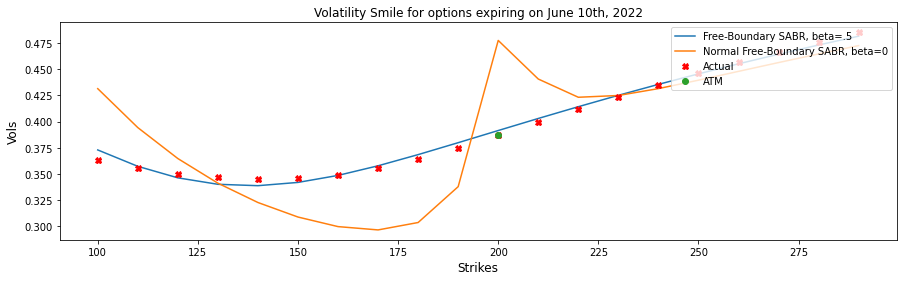

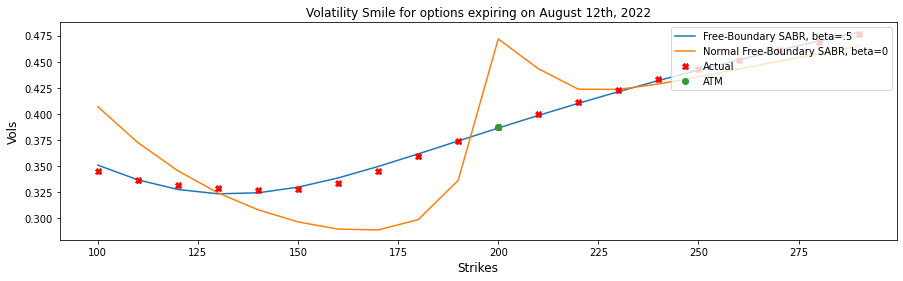

In [146]:
# Free-Boundary SABR Volatility model

freeSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, method="floch-kennedy", label="Free-Boundary SABR, beta=.5")
freeSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, method="floch-kennedy", label="Normal Free-Boundary SABR, beta=0")

SABRComparison([freeSABR_beta5, freeSABR_beta0], title="Free-Boundary SABR")

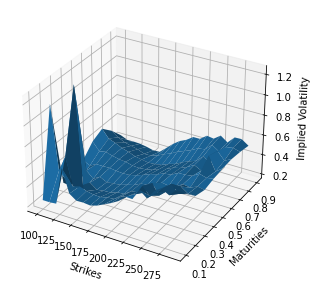

In [147]:
#DUPIRE LOCAL VOLATILITY SURFACE (NOT PLOTTABLE)

black_var_surface.setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)
#if does not work use NoExceptLocalVolSurface
# local_vol_surface = ql.LocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote)
local_vol_surface = ql.NoExceptLocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote, .25)

# Plot the Dupire surface ...
local_vol_surface.enableExtrapolation()
plot_vol_surface(local_vol_surface, funct='localVol')


In [148]:
#HESTON MODEL SURFACE PLOTTING (Levenberg-Marquardt Method)

class hestonModelSurface:
    def __init__(self, params, label=""):
        (self.v0, self.kappa, self.theta, self.sigma, self.rho) = params
        self.label = label
        self.strks, self.marketValue, self.modelValue, self.relativeError = ([], [], [], [])
        
        self.initialize()

    def initialize(self):
        process = ql.HestonProcess(flat_ts, dividend_ts, 
                                ql.QuoteHandle(ql.SimpleQuote(current_price)), 
                                self.v0, self.kappa, self.theta, self.sigma, self.rho)
        self.hestonModel = ql.HestonModel(process)
        self.engine = ql.AnalyticHestonEngine(self.hestonModel) 
        self.errors = []

        self.heston_helpers = []
        black_var_surface.setInterpolation("bicubic")
        one_year_idx = -1 
        date = dates[one_year_idx]

        for j, s in enumerate(strikes):
            t = (date - today)
            p = ql.Period(t, ql.Days)
            sigma = vols[one_year_idx][j]

            helper = ql.HestonModelHelper(p, calendar, current_price, s, 
                                        ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                        flat_ts, 
                                        dividend_ts)
            helper.setPricingEngine(self.engine)
            self.heston_helpers.append(helper)

        lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
        self.hestonModel.calibrate(self.heston_helpers, lm, 
                        ql.EndCriteria(500, 300, 1.0e-8, 1.0e-8, 1.0e-8))
        self.v0, self.kappa, self.theta, self.sigma, self.rho = self.hestonModel.params()

        self.set_surface()
        self.compute_errors()

    def set_surface(self):
        # Boilerplate to get to the Vol Surface object
        heston_handle = ql.HestonModelHandle(self.hestonModel)
        self.heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)
        self.heston_vol_surface.enableExtrapolation()

        # compute errors
        for j in range(len(dates)):
            heston_vols = [self.heston_vol_surface.blackVol(dates[j], s) for s in strikes]
            error = ((heston_vols - np.array(vols[i]))**2 ).mean() **.5
            self.errors.append(error)
        

    def compute_errors(self):
        # Statistical analysis on the Heston model and plotting

        self.avgError = 0
        for i, opt in enumerate(self.heston_helpers):
            err = (opt.modelValue()/opt.marketValue() - 1.0)
            self.strks.append(strikes[i]); self.marketValue.append(opt.marketValue())
            self.modelValue.append(opt.modelValue())
            self.relativeError.append(100.0*(opt.modelValue()/opt.marketValue() - 1.0))
            self.avgError += abs(err)
        self.avgError = self.avgError*100.0/len(self.heston_helpers)
        self.to_data()

    def to_data(self):
        self.errors_data = pd.DataFrame({"Strikes": self.strks, "Market Value": self.marketValue, "Model Value": self.modelValue, "Relative Error (%)": self.relativeError})
        self.var_data = pd.DataFrame(data=[self.v0, self.kappa, self.theta, self.sigma, self.rho, self.avgError], index=[ "v0", "kappa", "theta", "sigma", "rho", "avgError"], columns=["Value"])

m1_params, m2_params = (None, None)

if data == "SPX":
    m1_params = (0.05,0.2,0.5,0.1,0.09)
    m2_params = (0.15,0.5,0.2,0.7,0.01)
elif data == "COFFEE":
    m1_params = (0.01,0.1,0.3,0.1,0.02)
    m2_params = (0.2,0.9,0.9,0.9,-0.19)
elif data == "OIL":
    m2_params = (0.023,0.009,1.00,0.95,0.2)
    m1_params = (0.15,0.5,0.2,0.7,0.01)
elif data == "GOLD":
    m1_params = (0.03,0.3,0.5,0.3,0.04)
    m2_params = (0.01,0.5,0.5,0.1,0.03)
else:
    m1_params = (0.03,0.3,0.5,0.3,0.04)
    m2_params = (0.01,0.5,0.5,0.1,0.03)

hestonModel1 = hestonModelSurface(m1_params, label="Model1")
hestonModel2 = hestonModelSurface(m2_params, label="Model2")

# Use to Calibrate first time the Heston Model
def calibrateHeston():
    def f(params):
        params[4] = min(params[4], .999)
        params[4] = max(params[4], -.999)
        params[3] = max(params[3], -.999)
        params[0] = max(params[0], 1e-8); params[1] = max(params[1], 1e-8)
        params[2] = max(params[2], 1e-8); params[3] = max(params[3], 1e-8)
        print(params)
        return hestonModelSurface(params, label="Model1").avgError
        # v0, kappa, theta, sigma, rho
    cons = (
            {'type': 'ineq', 'fun': lambda x: x[0] - 0.001},
            {'type': 'ineq', 'fun': lambda x: 2. - x[0]},
            {'type': 'ineq', 'fun': lambda x: x[1] - 0.001},
            {'type': 'ineq', 'fun': lambda x: 2. - x[1]},
            {'type': 'ineq', 'fun': lambda x: x[2] - 0.001},
            {'type': 'ineq', 'fun': lambda x: 2. - x[2]},
            {'type': 'ineq', 'fun': lambda x: x[3] - 0.001},
            {'type': 'ineq', 'fun': lambda x: .999 - x[3]},
            {'type': 'ineq', 'fun': lambda x: .99 - x[4]**2}
            ) 
    result = minimize(f, m1_params, constraints=cons, method="SLSQP")
    hestonModel0 = hestonModelSurface(result["x"], label="Model0")


    plot_vol_surface(hestonModel0.heston_vol_surface, title="Heston Volatility Surface for {}".format(hestonModel0.label))
    plot_vol_surface(hestonModel1.heston_vol_surface, title="Heston Volatility Surface for {}".format(hestonModel1.label))

init_conditions = pd.DataFrame({"theta": [m1_params[0], m2_params[0]], "kappa": [m1_params[1], m2_params[1]], 
                                "sigma": [m1_params[2], m2_params[2]], "rho": [m1_params[3], m2_params[3]], 
                                "v0": [m1_params[4], m2_params[4]]}, index = ["Model1","Model2"])
display(init_conditions.style.set_caption("HESTON MODEL INITIAL CONDITIONS ({})".format(data)))

In [149]:
hestonModel1.errors

[0.17647199357638538,
 0.012709043945552261,
 0.01130445241852662,
 0.007538851479000715,
 0.005101193604381454,
 0.0025889379091932987,
 0.0020023294038189403]

No handles with labels found to put in legend.


No handles with labels found to put in legend.


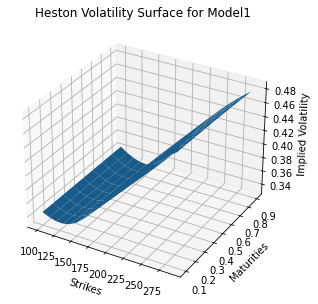

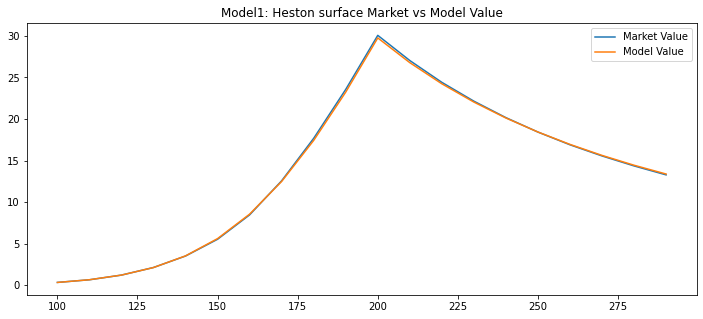

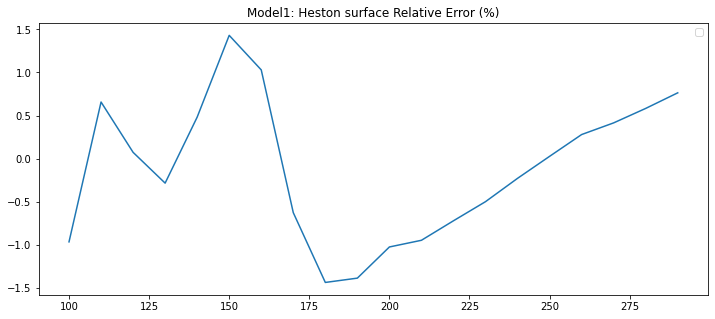

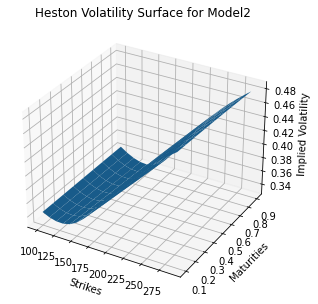

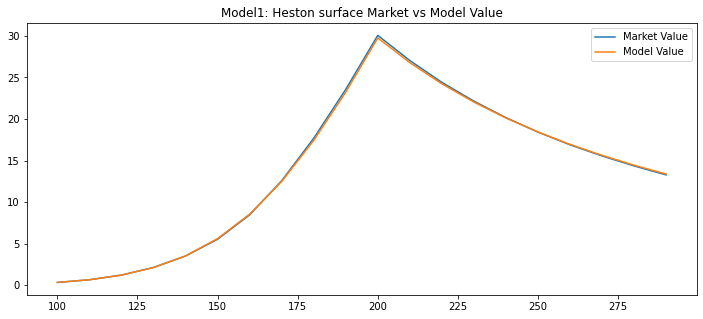

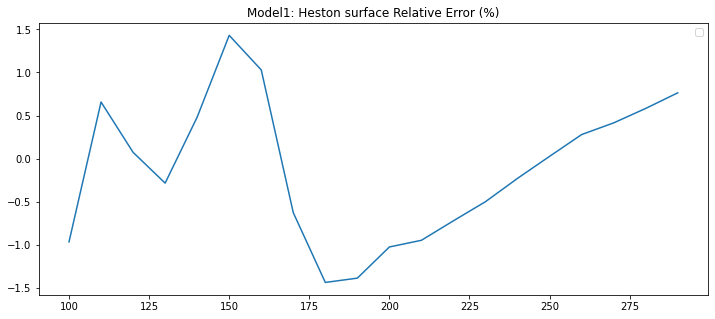

In [150]:
# HESTON Surface Plotting (Model1, Model2)

for model in (hestonModel1, hestonModel2):
    plot_vol_surface(model.heston_vol_surface, title="Heston Volatility Surface for {}".format(model.label))
    display(model.errors_data.style.set_caption("{} calibration results".format(model.label))); display(model.var_data.style.set_caption("{} parameters output".format(model.label)))

    fig1 = plt.figure(figsize=plot_size)
    plt.plot(model.strks, model.marketValue, label="Market Value")
    plt.plot(model.strks, model.modelValue, label="Model Value")
    plt.title('Model1: Heston surface Market vs Model Value'); plt.xlabel='strikes'; plt.ylabel='value'
    plt.legend()
    fig2 = plt.figure(figsize=plot_size)
    plt.plot(model.strks, model.relativeError)
    plt.title('Model1: Heston surface Relative Error (%)'); plt.xlabel='strikes'; plt.ylabel='value'
    plt.legend()

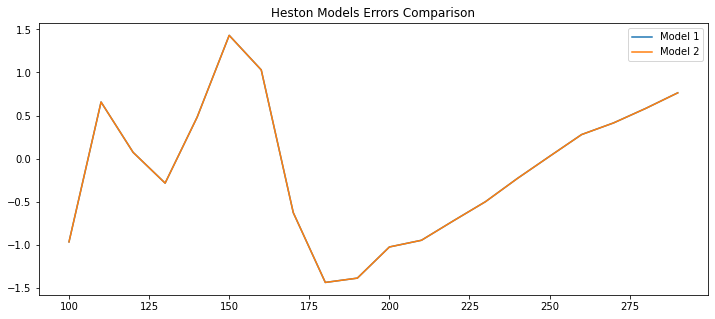

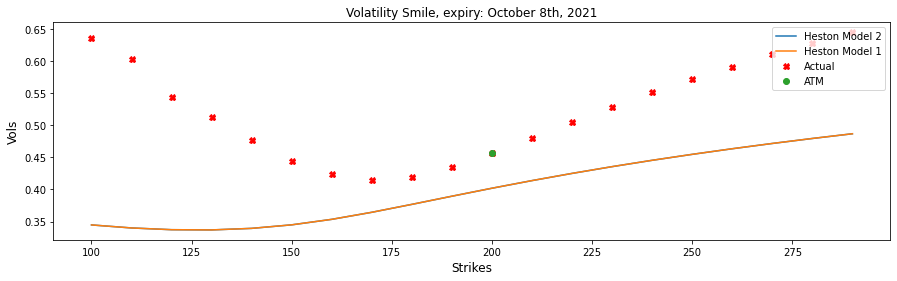

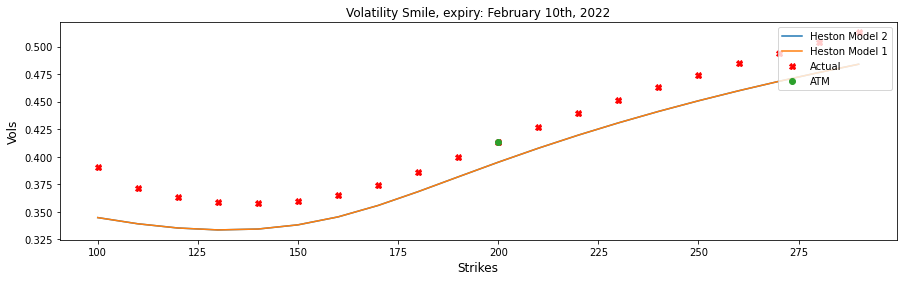

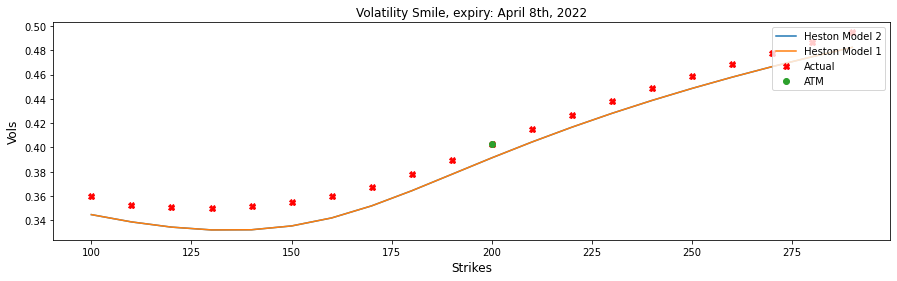

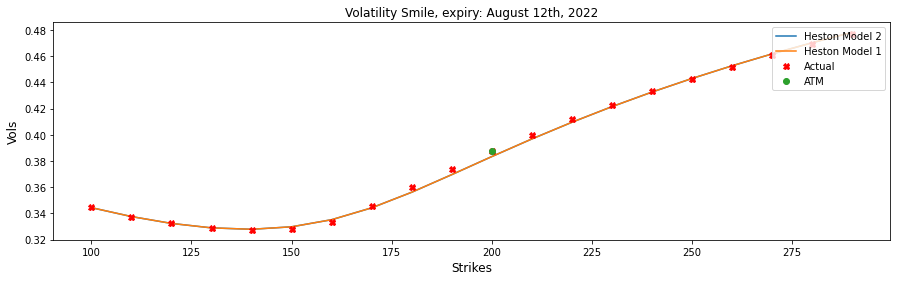

In [151]:
# Relative error comparison
plt.figure(figsize=plot_size)
plt.plot(hestonModel1.strks, hestonModel1.relativeError, label="Model 1")
plt.plot(hestonModel2.strks, hestonModel2.relativeError, label="Model 2")
plt.title("Heston Models Errors Comparison");
plt.legend()

# Volatility smiles comparison
tenors = [dates[round((len(dates)-1) * x)] for x in (.2, .5, .75, 1)]
for tenor in tenors:
    l = [
        ([hestonModel2.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston Model 2" ),
        ([hestonModel1.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston Model 1" )
        ]
    plot_smile(tenor, l, market=True, title="Volatility Smile, expiry: {}".format(tenor))

alpha_free  beta_free   nu_free  rho_free   alpha_N  \
September 10th, 2021    6.335495        0.5  3.236817       0.0  6.335495   
October 8th, 2021       6.687495        0.5  1.044051       0.0  6.687495   
November 12th, 2021     6.582879        0.5  0.014435       0.0  6.582879   
February 10th, 2022     5.721576        0.5  0.001000       0.0  5.721576   
April 8th, 2022         5.536920        0.5  0.001000       0.0  5.536920   
June 10th, 2022         5.409097        0.5  0.009464       0.0  5.409097   
August 12th, 2022       5.272536        0.5  0.001000       0.0  5.272536   

                      beta_N      nu_N     rho_N       MSE  
September 10th, 2021     0.0  6.473635  0.293095  0.096496  
October 8th, 2021        0.0  2.088103  0.990000  0.088550  
November 12th, 2021      0.0  0.028870  0.990000  0.220692  
February 10th, 2022      0.0  0.002000  0.872102  0.235309  
April 8th, 2022          0.0  0.002000  0.872575  0.237184  
June 10th, 2022          0.0  0.018928  0.990000  0.236764  
August 12th, 2022        0.0  0.002000  0.859009  0.240596

No handles with labels found to put in legend.


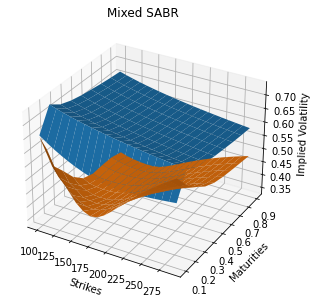

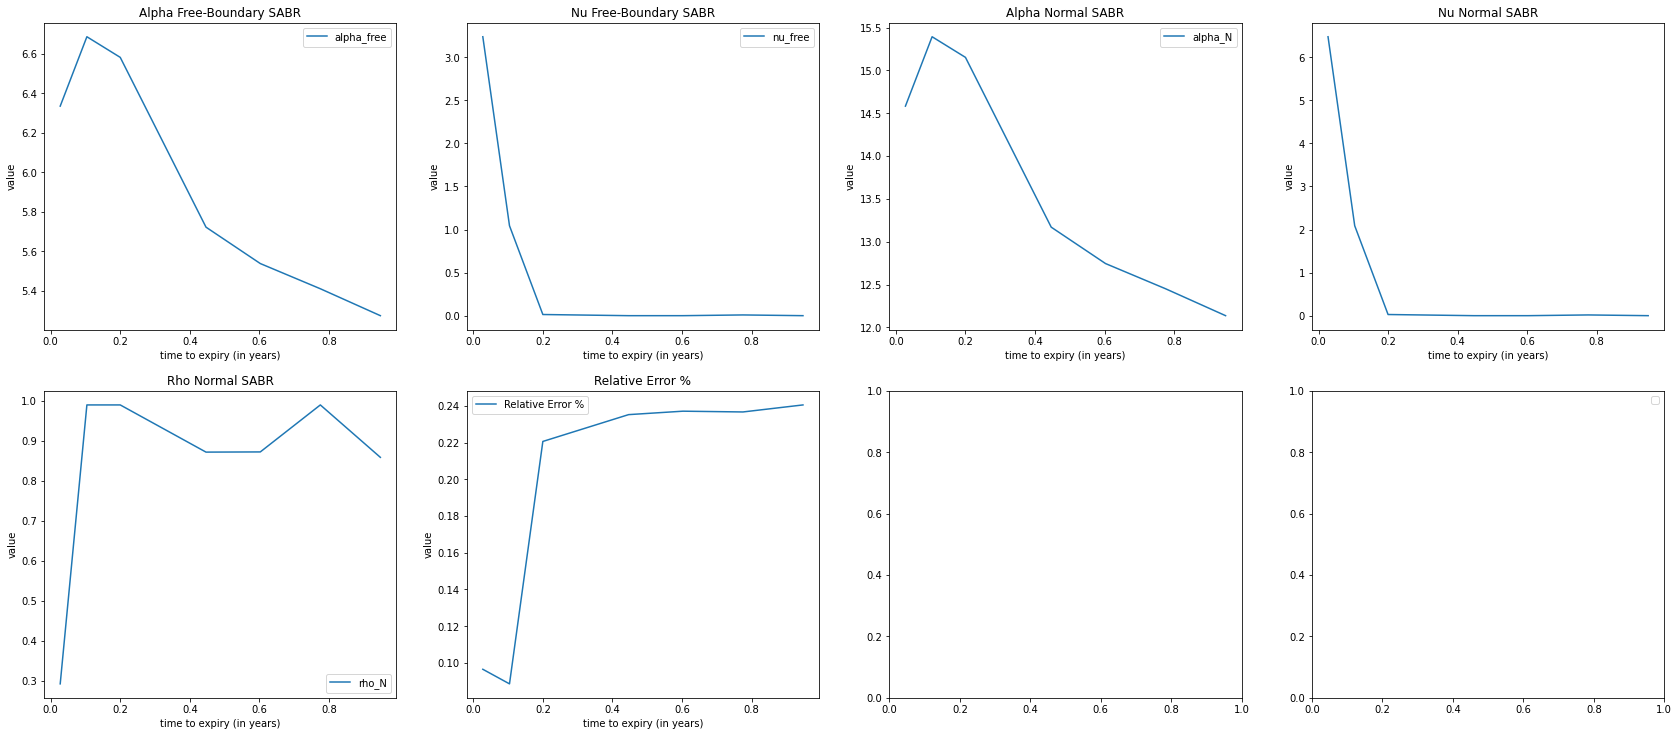

In [152]:
# MIXTURE SABR

class MixtureSABRSmile:
    def __init__(self, date, fwd=current_price, s=0):
        self.date = date
        self.expiryTime = round((self.date - today)/365, 6)
        self.marketVols = vols[dates.index(self.date)]
        self.fwd = fwd
        self.s = s
        self.alpha_N = .1; self.beta_N = 0.; self.nu_N = .1; self.rho_N = .1
        self.alpha_free = .1; self.beta_free = .5; self.nu_free = .1; self.rho_free = 0.
        
        self.initialize()

    def initialize(self):

        # # calibrate the Free Zero-Correlation SABR first
        self.freeSABR = SABRSmile(
            date=self.date, beta=.5, method="floch-kennedy", fwd=self.fwd, zero_rho=True)
        self.freeSABR.initialize()
        self.alpha_free = self.freeSABR.alpha
        self.beta_free = self.freeSABR.beta
        self.nu_free = self.freeSABR.nu

        # alpha, beta, nu, rho (Normal, free)
        cons = (
            {'type': 'eq', 'fun': lambda x: x[0] - self.alpha_free * \
                math.log(current_price)**self.beta_free},
            {'type': 'eq', 'fun': lambda x: x[4] - self.alpha_free},
            {'type': 'eq', 'fun': lambda x: x[1]},
            {'type': 'eq', 'fun': lambda x: x[5] - self.beta_free},
            {'type': 'eq', 'fun': lambda x: x[2] - \
                self.nu_free / (1 - self.beta_free)},
            {'type': 'eq', 'fun': lambda x: x[6] - self.nu_free},
            {'type': 'ineq', 'fun': lambda x: x[3]},
            {'type': 'ineq', 'fun': lambda x: .99 - x[3]},
            {'type': 'eq', 'fun': lambda x: x[7]},
        )

        # Set initial conditions
        x = [self.alpha_N, self.beta_N, self.nu_N, self.rho_N, self.alpha_free, self.beta_free, self.nu_free, self.rho_free]

        result = minimize(self.f, x, constraints=cons, method="SLSQP")
        self.error = result['fun']
        params = [self.alpha_N, self.beta_N, self.nu_N, self.rho_N, self.alpha_free,
                  self.beta_free, self.nu_free, self.rho_free] = result['x']

        self.newVols = [self.calibrate_volatilities(
            strike, params) for strike in strikes]

    def calibrate_volatilities(self, strike, params):

        p = (params[0] * params[5] * math.exp(self.s)) / \
            ((params[0] * params[5] * math.exp(self.s)) + abs(params[2] * params[3]))

        normalSABR = ql.sabrVolatility(
            strike, self.fwd, self.expiryTime, *params[:4])

        return math.sqrt((p**2) * self.freeSABR.newVols[int(np.where(strikes == strike)[0])] + ((1-p)**2) * normalSABR)

    def f(self, params):

        mixture_vols = np.array([self.calibrate_volatilities(
            strike, params) for strike in strikes])

        self.error = ((mixture_vols - np.array(self.marketVols))**2).mean() ** .5

        return self.error


class MixtureSABRVolatilitySurface:
    def __init__(self, fwd=current_price, label="", dates=dates):
        self.fwd = fwd
        self.label = label
        self.dates = dates
        self.vol_surface_vector, self.errors = [], []
        self.alpha_N, self.beta_N, self.nu_N, self.rho_N = [], [], [], []
        self.alpha_free, self.beta_free, self.nu_free, self.rho_free = [], [], [], []

        self.initialize()

    def initialize(self):
        self.SABRVolMatrix, self.SABRVolDiffMatrix = (
            ql.Matrix(len(strikes), len(self.dates)), 
            ql.Matrix(len(strikes), len(self.dates))
            )

        for i, d in enumerate(self.dates):
            volMixedSABR = MixtureSABRSmile(date=d, fwd=self.fwd)

            self.alpha_N.append(volMixedSABR.alpha_N)
            self.alpha_free.append(volMixedSABR.alpha_free)
            self.beta_N.append(volMixedSABR.beta_N)
            self.beta_free.append(volMixedSABR.beta_free)
            self.nu_N.append(volMixedSABR.nu_N)
            self.nu_free.append(volMixedSABR.nu_free)
            self.rho_N.append(volMixedSABR.rho_N)
            self.rho_free.append(volMixedSABR.rho_free)

            self.errors.append(volMixedSABR.error)

            smile = volMixedSABR.newVols
            self.vol_surface_vector.extend(smile)

            # constructing the SABRVolatilityMatrix
            for j in range(len(smile)):
                self.SABRVolMatrix[j][i] = smile[j]
                self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]

            self.vol_surface = ql.BlackVarianceSurface(
                today, calendar, self.dates, strikes, self.SABRVolMatrix, day_count)
            self.vol_surface.enableExtrapolation()

    def to_data(self):
        d = {'alpha_free': self.alpha_free, 'beta_free': self.beta_free, 'nu_free': self.nu_free, 'rho_free': self.rho_free,
             'alpha_N': self.alpha_free, 'beta_N': self.beta_N, 'nu_N': self.nu_N, 'rho_N': self.rho_N,
             'MSE': self.errors,
             }
        return pd.DataFrame(data=d, index=self.dates)

    def plot(self):
        fig, axs = plt.subplots(2, 4, figsize=plot_size)
        plt.subplots_adjust(right=2, top=2)

        x_values = [(x-today)/365. for x in self.dates]

        axs[0, 0].plot(x_values, self.alpha_free, label="alpha_free")
        axs[0, 0].set_title('Alpha Free-Boundary SABR')
        axs[0, 0].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[0, 0].legend()
        axs[0, 1].plot(x_values, self.nu_free, label="nu_free")
        axs[0, 1].set_title('Nu Free-Boundary SABR')
        axs[0, 1].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[0, 1].legend()
        axs[0, 2].plot(x_values, self.alpha_N, label="alpha_N")
        axs[0, 2].set_title('Alpha Normal SABR')
        axs[0, 2].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[0, 2].legend()
        axs[0, 3].plot(x_values, self.nu_N, label="nu_N")
        axs[0, 3].set_title('Nu Normal SABR')
        axs[0, 3].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[1, 3].legend()
        axs[1, 0].plot(x_values, self.rho_N, label="rho_N")
        axs[1, 0].set_title('Rho Normal SABR')
        axs[1, 0].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[1, 0].legend()
        axs[1, 1].plot(x_values, self.errors, label="Relative Error %")
        axs[1, 1].set_title('Relative Error %')
        axs[1, 1].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[1, 1].legend()

tenors = dates[6:] if data == "SPX" else dates
mixtureSABR = MixtureSABRVolatilitySurface(dates=tenors, label="Mixed SABR") 
display(mixtureSABR.to_data())
plot_vol_surface([mixtureSABR.vol_surface, black_var_surface], title="Mixed SABR")
mixtureSABR.plot()

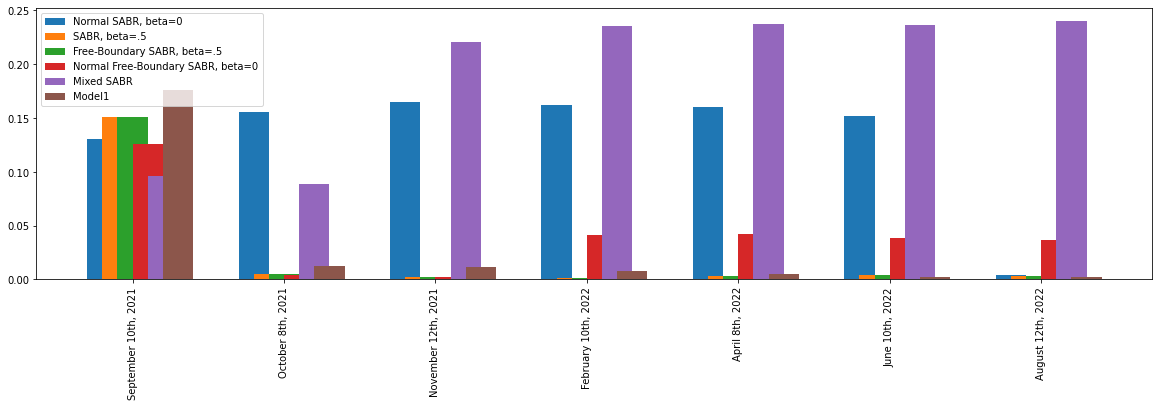

In [153]:
# VOLATILITY SMILES ERRORS COMPARISON

# fix Mixture SABR errors due to missing dates
mixtureSABR_errors = None
if data == "SPX":
    np.concatenate((np.zeros(6), mixtureSABR.errors))
else:
     mixtureSABR_errors = mixtureSABR.errors

fig = plt.figure(figsize=(20, 5), )
width = .20
plt.bar(np.arange(len(maturities)) - 2*width/2, SABR_beta0.errors, label=SABR_beta0.label, width=width)
plt.bar(np.arange(len(maturities)) - width/2, SABR_beta5.errors, label=SABR_beta5.label, width=width)
plt.bar(np.arange(len(maturities)) , freeSABR_beta5.errors, label=freeSABR_beta5.label, width=width)
plt.bar(np.arange(len(maturities)) + width/2, freeSABR_beta0.errors, label=freeSABR_beta0.label, width=width)
plt.bar(np.arange(len(maturities)) + 2*width/2, mixtureSABR_errors, label=mixtureSABR.label, width=width)
plt.bar(np.arange(len(maturities)) + 3*width/2, hestonModel1.errors, label=hestonModel1.label, width=width)
plt.xticks(np.arange(len(maturities)), dates, rotation='vertical')
plt.legend()

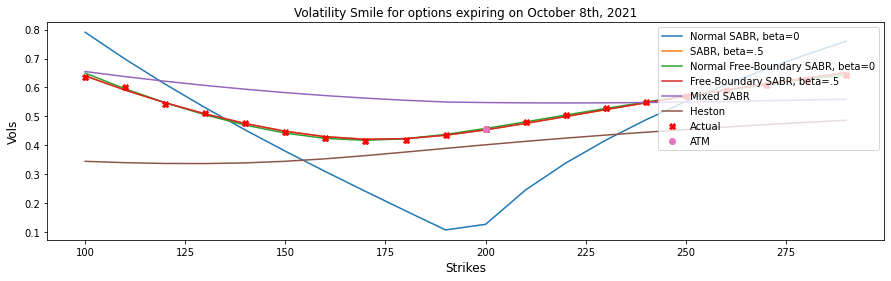

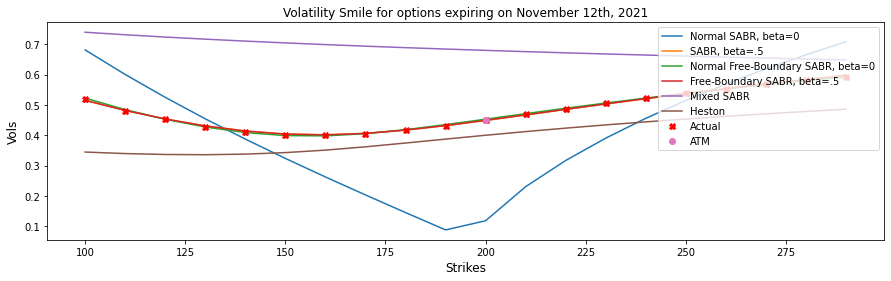

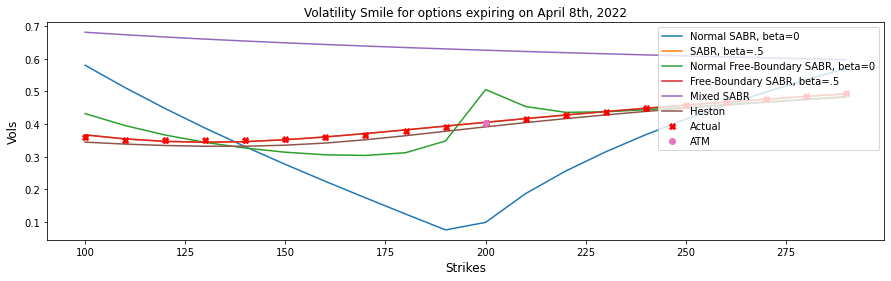

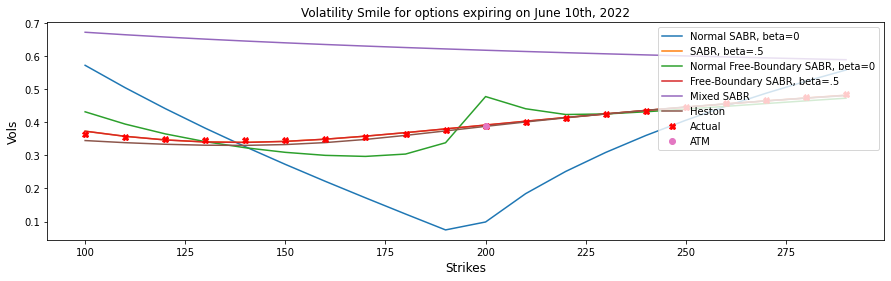

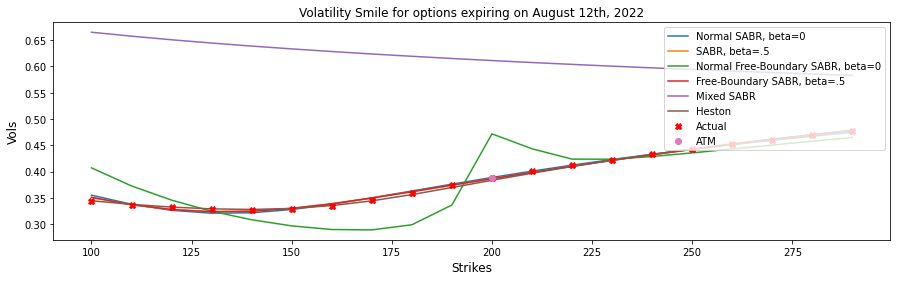

In [154]:
# Volatility Smiles Comparisons (Final)

models = (
        SABR_beta0, SABR_beta5, 
        freeSABR_beta0, freeSABR_beta5,
        mixtureSABR
        )
smiles_comparison(models, heston_models=[hestonModel1])

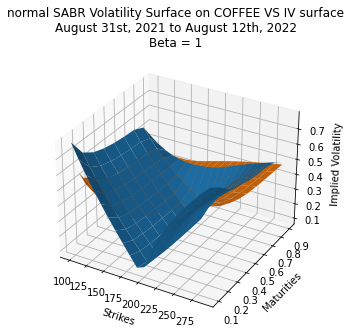

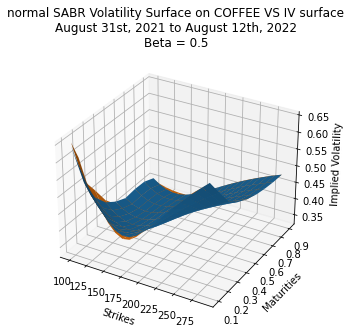

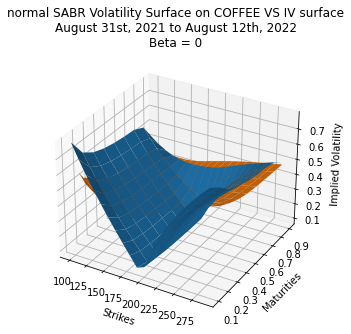

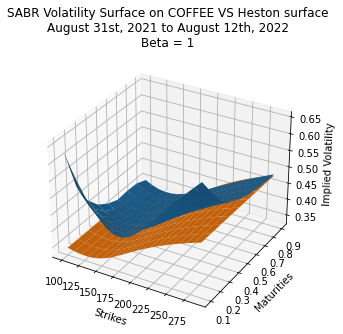

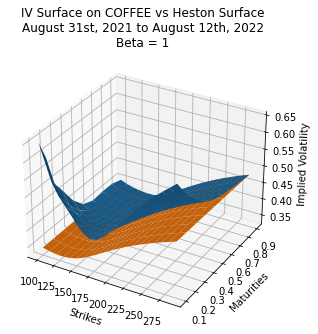

In [155]:
# Volatility Surfaces plots comparison

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0.5".format(data, today, dates[-1])
plot_vol_surface([SABR_beta5.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0".format(data, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "SABR Volatility Surface on {} VS Heston surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([SABR_beta1.vol_surface, hestonModel1.heston_vol_surface], title=title)

title = "IV Surface on {} vs Heston Surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([black_var_surface, hestonModel1.heston_vol_surface], title=title)